### CoNLL2003 dataset 이용

- CoNLL -  the Conference on Natural Language Learning  


- https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt  에서 download  



- `[word][pos Tagging][chunk tagging][named entity tagging]` 의 4 column 형식으로 구성   


- NE(Named Entity) tagging :   
    LOC - location,   
    ORG - organization,  
    PER - person,   
    MISC - miscellaneous,   
    B - phrase 시작,   
    I - inside phrase,   
    O - phrase 의 일부가 아님
```
The DT B-NP O                             # 개체명 아님               
European NNP I-NP B-ORG            # ORG type phrase 시작
Commission NNP I-NP I-ORG         # phrase 에 속함 - ORG
said VBD B-VP O                           # 개체명 아님
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC                # MISC type phrase 시작
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP O
to TO B-VP O
shun VB I-VP O
```

In [1]:
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
file_path = tf.keras.utils.get_file("train.txt",
    "https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt")

3283420/3283420 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
for line in open(file_path, 'r').readlines()[:20]:
  print(repr(line))

'-DOCSTART- -X- -X- O\n'
'\n'
'EU NNP B-NP B-ORG\n'
'rejects VBZ B-VP O\n'
'German JJ B-NP B-MISC\n'
'call NN I-NP O\n'
'to TO B-VP O\n'
'boycott VB I-VP O\n'
'British JJ B-NP B-MISC\n'
'lamb NN I-NP O\n'
'. . O O\n'
'\n'
'Peter NNP B-NP B-PER\n'
'Blackburn NNP I-NP I-PER\n'
'\n'
'BRUSSELS NNP B-NP B-LOC\n'
'1996-08-22 CD I-NP O\n'
'\n'
'The DT B-NP O\n'
'European NNP I-NP B-ORG\n'


In [4]:
tag_sentences = []
sentence = []

for line in open(file_path, 'r'):
  if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == '\n':
    if len(sentence) > 0:
      tag_sentences.append(sentence)
      sentence = []
    continue

  word, pos_tag, chunk_tag, ner = line.split(' ')
  ner = re.sub("\n", '', ner)
  word = word.lower()
  sentence.append((word, ner))

In [5]:
sentence

[]

In [7]:
len(tag_sentences)

14041

In [5]:
inputs, labels = [], []

for pairs in tag_sentences:
  words, tags = zip(*pairs)
  inputs.append(list(words))
  labels.append(list(tags))
################################
print(inputs[0])
print(labels[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


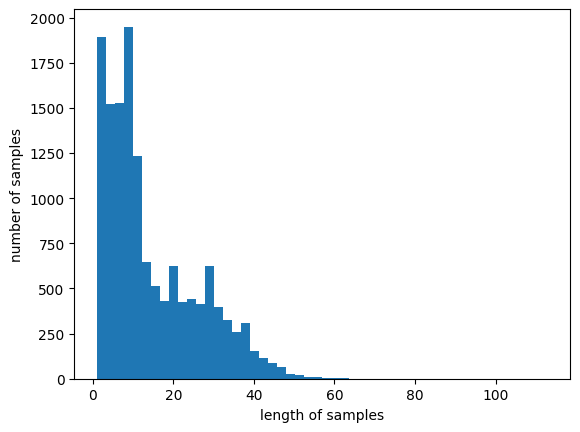

In [6]:
print('샘플의 최대 길이 : {}'.format(max([len(w) for w in inputs])))
print('샘플의 평균 길이 : {:4f}'.format(np.mean([len(w) for w in inputs])))
plt.hist([len(s) for s in inputs], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [6]:
MAX_LENGTH = 60

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(inputs)
print(len(tokenizer.word_index))

21009


In [8]:
MAX_WORDS = 4000

In [9]:
train_sentences, test_sentences, train_tags, test_tags = \
 train_test_split(inputs, labels, test_size=0.2)

print(len(train_sentences), "  ", len(test_sentences))
print(len(train_tags), "  ", len(test_tags))

11232    2809
11232    2809


In [10]:
entity_tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
entity_tokenizer.fit_on_texts(train_sentences)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(labels)

vocab_size = entity_tokenizer.num_words + 1
tag_size = len(tag_tokenizer.word_index) + 1
print("vocab_size: ", vocab_size)
print("tag_size: ", tag_size)

vocab_size:  4001
tag_size:  10


In [21]:
tag_tokenizer.word_index

{'o': 1,
 'b-loc': 2,
 'b-per': 3,
 'b-org': 4,
 'i-per': 5,
 'i-org': 6,
 'b-misc': 7,
 'i-loc': 8,
 'i-misc': 9}

In [11]:
X_train = entity_tokenizer.texts_to_sequences(train_sentences)
y_train = tag_tokenizer.texts_to_sequences(train_tags)

X_test = entity_tokenizer.texts_to_sequences(test_sentences)
y_test = tag_tokenizer.texts_to_sequences(test_tags)

print(len(X_train), " ", len(y_train))
print(len(X_test), " ", len(y_test))

11232   11232
2809   2809


In [27]:
print(X_train[-1])
print(y_train[-1])

[2, 717, 3534, 30]
[1, 1, 1, 1]


In [12]:
X_train_padded = pad_sequences(X_train, maxlen=MAX_LENGTH,padding='post')
X_test_padded = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

y_train_padded = pad_sequences(y_train, maxlen=MAX_LENGTH, padding='post')
y_test_padded = pad_sequences(y_test, maxlen=MAX_LENGTH, padding='post')

In [29]:
X_train_padded

array([[ 107,  318,    0, ...,    0,    0,    0],
       [ 711,    0,    0, ...,    0,    0,    0],
       [3944,   23,   22, ...,    0,    0,    0],
       ...,
       [ 107,  150,    0, ...,    0,    0,    0],
       [ 104,   30,    1, ...,    0,    0,    0],
       [   2,  717, 3534, ...,    0,    0,    0]], dtype=int32)

In [32]:
print(X_train_padded[-1])
print(X_test_padded[0])

[   2  717 3534   30    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[303  18 195   1  19   1  13 596 172 157 409   3   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [38]:
print(y_train_padded[-1])
print(y_test_padded[0])

1
1


In [13]:
y_train_onehot = to_categorical(y_train_padded, tag_size)
y_test_onehot = to_categorical(y_test_padded, tag_size)
print(y_train_onehot[0][0])
print(y_test_onehot[0][0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dense(tag_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
%%time
hist = model.fit(X_train_padded, y_train_onehot, batch_size=128, epochs=10,
                 validation_data=(X_test_padded, y_test_onehot))

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8666 - loss: 0.4852 - val_accuracy: 0.9603 - val_loss: 0.1569
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9602 - loss: 0.1443 - val_accuracy: 0.9714 - val_loss: 0.0961
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9732 - loss: 0.0889 - val_accuracy: 0.9798 - val_loss: 0.0682
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9819 - loss: 0.0607 - val_accuracy: 0.9848 - val_loss: 0.0528
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9876 - loss: 0.0430 - val_accuracy: 0.9874 - val_loss: 0.0439
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9901 - loss: 0.0343 - val_accuracy: 0.9883 - val_loss: 0.0410
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9912 - loss: 0.0295 - val_accuracy: 0.9885 - val_loss: 0.0387
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9922 - loss: 0.0264 - val_accuracy: 0.9891 - v

In [17]:
score = model.evaluate(X_test_padded, y_test_onehot)
print(score[1] * 100)

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9896 - loss: 0.0357
98.94682168960571


In [18]:
test_sample = ["EU gave German call to take British people"]

In [20]:
test_sample_tokenized = entity_tokenizer.texts_to_sequences(test_sample)
print(test_sample_tokenized)

test_sample_padded = pad_sequences(test_sample_tokenized, maxlen=MAX_LENGTH, padding='post')
print(test_sample_padded)

[[1345, 415, 213, 664, 7, 236, 201, 93]]
[[1345  415  213  664    7  236  201   93    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [24]:
y_pred = model.predict(test_sample_padded)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[[9.75773495e-04, 3.94187383e-02, 2.43585426e-02, 1.73918493e-02,
         8.67594957e-01, 9.92458547e-04, 1.71888736e-03, 4.22631316e-02,
         2.92372541e-03, 2.36191694e-03],
        [2.28784188e-06, 9.99750197e-01, 5.03623824e-07, 7.92551816e-07,
         3.94041581e-06, 6.79862751e-07, 1.47862656e-05, 3.55977572e-05,
         5.05890876e-06, 1.86104036e-04],
        [1.06958505e-05, 5.36689116e-03, 1.41619457e-05, 1.59992298e-04,
         6.96578645e-04, 5.32075433e-07, 1.91461695e-05, 9.92514312e-01,
         3.08312656e-06, 1.21454662e-03],
        [3.06182756e-07, 9.99824464e-01, 9.09989240e-09, 1.51741844e-07,
         4.08071827e-07, 5.20472952e-07, 1.48061454e-05, 3.23460245e-06,
         7.10311383e-07, 1.55382149e-04],
        [1.26083544e-09, 1.00000000e+00, 1.41368209e-10, 4.77760886e-11,
         2.05269512e-09, 9.33089890e-12, 3.33349326e-09, 6.79034518e-09,
         1.45200657e-10, 3.85915548e-08],
        [1.54457318e-08, 9.99998331e-01, 2.26111663e-08, 4.3

In [25]:
y_pred = y_pred.argmax(axis=-1)
y_pred

array([[4, 1, 7, 1, 1, 1, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
test_sample_tokenized

[[1345, 415, 213, 664, 7, 236, 201, 93]]

In [28]:
index2word = entity_tokenizer.index_word
index2tag = tag_tokenizer.index_word

In [29]:
for i in range(len(test_sample_tokenized[0])):
  print(index2word.get(test_sample_tokenized[0][i]))

eu
gave
german
call
to
take
british
people


In [31]:
[index2word.get(x, '?') for x in test_sample_tokenized[0]]

['eu', 'gave', 'german', 'call', 'to', 'take', 'british', 'people']

In [33]:
[index2tag.get(y) for y in y_pred[0]]

['b-org',
 'o',
 'b-misc',
 'o',
 'o',
 'o',
 'b-misc',
 'o',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [34]:
for i in range(len(test_sample_tokenized)):
  for word, tag in zip([index2word.get(x, '?') for x in test_sample_tokenized[i]],
                       [index2tag.get(y, '?') for y in y_pred[i]]):
    if word != '<OOV>' and word != '?' and tag != '?':
      print(f'{word}: {tag.upper()}')

eu: B-ORG
gave: O
german: B-MISC
call: O
to: O
take: O
british: B-MISC
people: O
